<a href="https://colab.research.google.com/github/ajeymr/Satellite-Image-Classification/blob/master/SAT_image_clf_v8_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and importing libraries

In [ ]:
!pip install keras
!pip install tensorflow
!pip install  -U keras-tuner
!pip install kerastuner-tensorboard-logger

print("keras and tensorflow installed")

     |████████████████████████████████| 71kB 6.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=9b434171fa6d5ccd6cd136aedf2077cceee087e25d33ddb73fd69e5dda69d4a0
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=0fd7d77530b7753d5d13d2f6034b3f3d97851ffba287ec91af8f40a61af5d17b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
keras and tensorflow installed


In [ ]:
from skimage.io import imshow
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner_tensorboard_logger import TensorBoardLogger
from kerastuner.tuners import Hyperband
import time

print("Libraries Imported")

Libraries Imported


## Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv('/content/drive/My Drive/Satellite image classification/X_train_sat4.csv', header = None)
X.shape

(400000, 3136)

In [ ]:
y = pd.read_csv('/content/drive/My Drive/Satellite image classification/y_train_sat4.csv', header = None)
y.shape

(400000, 4)

In [ ]:
X_test = pd.read_csv('/content/drive/My Drive/Satellite image classification/X_test_sat4.csv', header = None)
X_test.shape

(99999, 3136)

In [ ]:
y_test = pd.read_csv('/content/drive/My Drive/Satellite image classification/y_test_sat4.csv', header = None)
y_test.shape

(100000, 4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X).astype('float32').reshape(400000,28,28,4)/255, np.array(y).astype('int32'), test_size = 0.2, random_state = 42)

In [ ]:
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)
print('y_train shape : ', y_train.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (320000, 28, 28, 4)
X_test shape :  (80000, 28, 28, 4)
y_train shape :  (320000, 4)
y_test shape :  (80000, 4)


## Data Visualization

In [ ]:
pd.DataFrame(X_train.reshape(320000,3136)).head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119,3120,3121,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,0.564706,0.568627,0.505882,0.737255,0.541176,0.533333,0.470588,0.729412,0.521569,0.498039,0.435294,0.709804,0.552941,0.533333,0.478431,0.733333,0.552941,0.541176,0.490196,0.749020,0.447059,0.407843,0.345098,0.639216,0.588235,0.592157,0.564706,0.780392,0.368627,0.333333,0.266667,0.509804,0.372549,0.333333,0.274510,0.494118,0.525490,0.517647,0.482353,0.713726,...,0.290196,0.270588,0.227451,0.321569,0.384314,0.392157,0.400000,0.486275,0.294118,0.270588,0.250980,0.333333,0.400000,0.415686,0.462745,0.521569,0.419608,0.462745,0.525490,0.572549,0.376471,0.388235,0.407843,0.498039,0.396078,0.411765,0.450980,0.521569,0.301961,0.286275,0.274510,0.341176,0.294118,0.274510,0.258824,0.329412,0.317647,0.294118,0.282353,0.345098
1,0.588235,0.537255,0.498039,0.635294,0.584314,0.537255,0.494118,0.635294,0.576471,0.533333,0.482353,0.635294,0.568627,0.525490,0.482353,0.643137,0.580392,0.537255,0.494118,0.647059,0.580392,0.537255,0.509804,0.666667,0.572549,0.533333,0.494118,0.647059,0.580392,0.537255,0.498039,0.654902,0.564706,0.521569,0.486275,0.658824,0.549020,0.505882,0.470588,0.654902,...,0.537255,0.490196,0.443137,0.588235,0.545098,0.501961,0.447059,0.588235,0.560784,0.517647,0.458824,0.588235,0.568627,0.521569,0.482353,0.600000,0.572549,0.521569,0.494118,0.611765,0.580392,0.529412,0.498039,0.607843,0.560784,0.509804,0.470588,0.596078,0.576471,0.521569,0.501961,0.592157,0.556863,0.501961,0.458824,0.588235,0.564706,0.513726,0.470588,0.596078
2,0.407843,0.427451,0.388235,0.537255,0.392157,0.439216,0.392157,0.521569,0.305882,0.341176,0.341176,0.482353,0.364706,0.368627,0.388235,0.466667,0.388235,0.341176,0.368627,0.415686,0.388235,0.341176,0.380392,0.423529,0.345098,0.329412,0.352941,0.447059,0.309804,0.376471,0.368627,0.564706,0.333333,0.372549,0.368627,0.572549,0.435294,0.439216,0.431373,0.611765,...,0.341176,0.388235,0.341176,0.529412,0.392157,0.368627,0.321569,0.513726,0.501961,0.462745,0.450980,0.576471,0.427451,0.341176,0.309804,0.607843,0.458824,0.411765,0.364706,0.678431,0.494118,0.486275,0.447059,0.756863,0.419608,0.415686,0.384314,0.647059,0.384314,0.388235,0.372549,0.525490,0.384314,0.400000,0.349020,0.415686,0.423529,0.411765,0.380392,0.447059
3,0.286275,0.290196,0.258824,0.564706,0.301961,0.313726,0.282353,0.588235,0.290196,0.290196,0.227451,0.549020,0.290196,0.301961,0.262745,0.564706,0.298039,0.313726,0.290196,0.564706,0.325490,0.349020,0.349020,0.592157,0.313726,0.341176,0.321569,0.596078,0.243137,0.258824,0.223529,0.572549,0.235294,0.270588,0.250980,0.639216,0.235294,0.270588,0.231373,0.654902,...,0.200000,0.223529,0.200000,0.603922,0.211765,0.247059,0.223529,0.631373,0.250980,0.282353,0.243137,0.670588,0.254902,0.290196,0.258824,0.682353,0.254902,0.290196,0.270588,0.682353,0.184314,0.192157,0.149020,0.619608,0.231373,0.262745,0.243137,0.658824,0.184314,0.172549,0.156863,0.607843,0.239216,0.262745,0.231373,0.662745,0.227451,0.254902,0.215686,0.654902
4,0.282353,0.250980,0.156863,0.513726,0.372549,0.364706,0.337255,0.603922,0.364706,0.380392,0.341176,0.615686,0.364706,0.384314,0.349020,0.607843,0.305882,0.274510,0.203922,0.490196,0.207843,0.137255,0.047059,0.384314,0.196078,0.117647,0.047059,0.403922,0.282353,0.247059,0.105882,0.513726,0.396078,0.435294,0.360784,0.701961,0.450980,0.513726,0.450980,0.768627,...,0.152941,0.086275,0.094118,0.235294,0.207843,0.200000,0.176471,0.356863,0.356863,0.400000,0.411765,0.580392,0.321569,0.349020,0.321569,0.552941,0.321569,0.329412,0.266667,0.568627,0.411765,0.435294,0.407843,0.674510,0.368627,0.407843,0.349020,0.662745,0.388235,0.423529,0.372549,0.698039,0.388235,0.415686,0.364706,0.690196,0.466667,0.513726,0.474510,0.756863


Trees


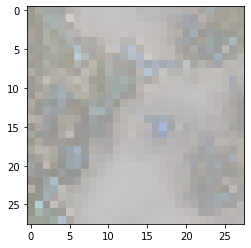

In [ ]:
ix = 67 # Row number
plt.imshow(np.squeeze(X_train[ix,:,:,:])) # Only show the RGB channels
if y_train[ix,0] == 1:
    print ('Barren Land')
elif y_train[ix,1] == 1:
    print ('Trees')
elif y_train[ix,2] == 1:
    print ('Grassland')
else:
    print ('Other')

## Exploring Basic Convolutional Neural Network

In [ ]:
tb_callbacks = keras.callbacks.TensorBoard(log_dir='./logs')

model = Sequential() # 1

# Preprocessing Layer
model.add(keras.layers.experimental.preprocessing.RandomContrast(0.5)) 
model.add(keras.layers.experimental.preprocessing.RandomFlip(mode = "horizontal_and_vertical"))
model.add(keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3)))

#Input layers
model.add(Conv2D(32, kernel_size =(3,3), input_shape = (28,28,4), padding = "same", activation = 'relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))

#Hidden layers
model.add(Conv2D(64, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))
model.add(Dropout(0.7))

model.add(Conv2D(128, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))
model.add(Dropout(0.5))

#Final fully connected layer
model.add(Flatten())
model.add(Dense(128, activation = 'relu', input_shape = (28,28,4)))

#Output layer
model.add(Dense(4, activation = 'softmax'))

model.compile(optimizer = 'SGD',
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy']
              )

In [ ]:
model.fit(
    X_train, 
    y_train, 
    batch_size = 64, 
    verbose=1, 
    validation_data=(X_test, y_test), 
    epochs=10, 
    callbacks=[tb_callbacks]
    )

Epoch 1/10
5000/5000 [==============================] - 37s 7ms/step - loss: 0.1070 - accuracy: 0.9641 - val_loss: 0.1018 - val_accuracy: 0.9644
Epoch 2/10
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0931 - accuracy: 0.9690 - val_loss: 0.1926 - val_accuracy: 0.9400
Epoch 3/10
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0756 - accuracy: 0.9743 - val_loss: 0.0835 - val_accuracy: 0.9705
Epoch 4/10
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0684 - accuracy: 0.9774 - val_loss: 0.0629 - val_accuracy: 0.9797
Epoch 5/10
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0631 - accuracy: 0.9790 - val_loss: 0.0670 - val_accuracy: 0.9781
Epoch 6/10
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0597 - accuracy: 0.9804 - val_loss: 0.0558 - val_accuracy: 0.9812
Epoch 7/10
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0559 - accuracy: 0.9816 - val_loss: 0.0643 - val_ac

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 28, 28, 4)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 28, 28, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0

## Better CNN

In [ ]:
tb_callbacks = keras.callbacks.TensorBoard(log_dir='./logs')

model2 = Sequential() # 2

# Preprocessing Layer
model2.add(keras.layers.experimental.preprocessing.RandomContrast(0.5)) 
model2.add(keras.layers.experimental.preprocessing.RandomFlip(mode = "horizontal_and_vertical"))
model2.add(keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3)))

#Input layers
model2.add(Conv2D(32, kernel_size =(3,3), input_shape = (28,28,4), padding = "same", activation = 'relu', data_format='channels_last'))
model2.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))

#Hidden layers
model2.add(Conv2D(64, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model2.add(Conv2D(64, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model2.add(Conv2D(64, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model2.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))
model2.add(Dropout(0.7))

model2.add(Conv2D(128, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model2.add(Conv2D(128, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model2.add(Conv2D(128, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model2.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))
model2.add(Dropout(0.7))

#Final fully connected layer
model2.add(Flatten())
model2.add(Dense(128, activation = 'relu', input_shape = (28,28,4)))

#Output layer
model2.add(Dense(4, activation = 'softmax'))

model2.compile(optimizer = 'SGD',
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy']
              )

In [ ]:
model2.fit(
    X_train, 
    y_train, 
    batch_size = 512, 
    verbose=1, 
    validation_data=(X_test, y_test), 
    epochs=10, 
    callbacks=[tb_callbacks]
    )

Epoch 1/10
625/625 [==============================] - 38s 59ms/step - loss: 1.2886 - accuracy: 0.3847 - val_loss: 1.1542 - val_accuracy: 0.4897
Epoch 2/10
625/625 [==============================] - 36s 57ms/step - loss: 0.9947 - accuracy: 0.5429 - val_loss: 0.9914 - val_accuracy: 0.5569
Epoch 3/10
625/625 [==============================] - 36s 57ms/step - loss: 0.7762 - accuracy: 0.6752 - val_loss: 0.6403 - val_accuracy: 0.7269
Epoch 4/10
625/625 [==============================] - 36s 57ms/step - loss: 0.5926 - accuracy: 0.7704 - val_loss: 0.4461 - val_accuracy: 0.8411
Epoch 5/10
625/625 [==============================] - 36s 57ms/step - loss: 0.4517 - accuracy: 0.8395 - val_loss: 0.2900 - val_accuracy: 0.9063
Epoch 6/10
625/625 [==============================] - 36s 57ms/step - loss: 0.3511 - accuracy: 0.8797 - val_loss: 0.4340 - val_accuracy: 0.8365
Epoch 7/10
625/625 [==============================] - 36s 57ms/step - loss: 0.2819 - accuracy: 0.9036 - val_loss: 0.1711 - val_accuracy:

In [ ]:
print("Model 2 Summary")
model2.summary()

Model 2 Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_2 (RandomCon (None, 28, 28, 4)         0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 28, 28, 4)         0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 28, 28, 4)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        1184      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14

## Hyperparameter tuning

In [ ]:
def build_model(hp):
  model = Sequential() # 4
  #model.add(keras.layers.experimental.preprocessing.RandomContrast(0.5)) 
  #model.add(keras.layers.experimental.preprocessing.RandomFlip(mode = "horizontal_and_vertical"))
  #model.add(keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3)))

  model.add(Conv2D(hp.Int('input_units',min_value = 32, max_value = 224, step = 64), kernel_size =(3,3), input_shape = (28,28,4), padding = "same", activation = 'relu', data_format='channels_last'))
  model.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))

  for i in range(hp.Int("n_layers",1,3)):
    model.add(Conv2D(hp.Int(f"conv_{i}_units",min_value = 32, max_value = 224, step = 64), kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
    # model.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))
    model.add(Dropout(0.7))

  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', input_shape = (28,28,4)))
  model.add(Dense(4, activation = 'softmax'))

  model.compile(optimizer = 'SGD',loss = 'categorical_crossentropy' , metrics = ['accuracy'])
  return model


In [ ]:
import time
LOG_DIR = f"{int(time.time())}"

tuner = Hyperband(
    build_model,
    objective = 'val_accuracy',
    max_epochs = 1000,
    executions_per_trial = 1,
    directory = LOG_DIR,
    project_name = 'layer_filter_variation3',
    logger = TensorBoardLogger(metrics = ["val_acc"], logdir = './logs')
)

In [ ]:
tuner.search(
    x = X_train,
    y = y_train,
    verbose = 1,
    epochs = 3,
    batch_size = 512,
    validation_data = (X_test,y_test)
)

Trial 437 Complete [00h 00m 46s]
val_accuracy: 0.8731625080108643

Best val_accuracy So Far: 0.9118750095367432
Total elapsed time: 05h 07m 08s

Search: Running Trial #438

Hyperparameter    |Value             |Best Value So Far 
input_units       |96                |96                
n_layers          |2                 |1                 
conv_0_units      |32                |160               
conv_1_units      |160               |224               
conv_2_units      |32                |96                
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |6                 |6                 
tuner/round       |0                 |0                 

Epoch 1/2
454/625 [====================>.........] - ETA: 3s - loss: 1.2101 - accuracy: 0.4271

KeyboardInterrupt: ignored

## Best Fit model

# New Section

In [ ]:
tb_callbacks = keras.callbacks.TensorBoard(log_dir='./logs')

model3 = Sequential()
# Preprocessing Layer
model3.add(keras.layers.experimental.preprocessing.RandomContrast(0.5)) 
model3.add(keras.layers.experimental.preprocessing.RandomFlip(mode = "horizontal_and_vertical"))
model3.add(keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3)))
#Input layers
model3.add(Conv2D(96, kernel_size =(3,3), input_shape = (28,28,4), padding = "same", activation = 'relu', data_format='channels_last'))
model3.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))

#Hidden layers 1
model3.add(Conv2D(160, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model3.add(Conv2D(224, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model3.add(Conv2D(96, kernel_size =(3,3), padding = "same", activation = 'relu', data_format='channels_last'))
model3.add(MaxPooling2D(pool_size = (2,2), data_format= 'channels_last'))
model3.add(Dropout(0.7))
#Final fully connected layer
model3.add(Flatten())
model3.add(Dense(128, activation = 'relu', input_shape = (28,28,4)))
#Output layer
model3.add(Dense(4, activation = 'softmax'))
#compiler
model3.compile(optimizer = 'SGD',
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy']
              )

In [ ]:
model3.fit(
    X_train, 
    y_train, 
    batch_size = 64, 
    verbose=1, 
    validation_data=(X_test, y_test), 
    epochs=10, 
    callbacks=[tb_callbacks]
    )

Epoch 1/10
5000/5000 [==============================] - 51s 10ms/step - loss: 0.7425 - accuracy: 0.6838 - val_loss: 0.3297 - val_accuracy: 0.8801
Epoch 2/10
5000/5000 [==============================] - 49s 10ms/step - loss: 0.2106 - accuracy: 0.9254 - val_loss: 0.0966 - val_accuracy: 0.9689
Epoch 3/10
5000/5000 [==============================] - 49s 10ms/step - loss: 0.1351 - accuracy: 0.9542 - val_loss: 0.1005 - val_accuracy: 0.9644
Epoch 4/10
5000/5000 [==============================] - 49s 10ms/step - loss: 0.0995 - accuracy: 0.9665 - val_loss: 0.0558 - val_accuracy: 0.9811
Epoch 5/10
5000/5000 [==============================] - 49s 10ms/step - loss: 0.0839 - accuracy: 0.9719 - val_loss: 0.0590 - val_accuracy: 0.9804
Epoch 6/10
5000/5000 [==============================] - 49s 10ms/step - loss: 0.0687 - accuracy: 0.9767 - val_loss: 0.0398 - val_accuracy: 0.9870
Epoch 7/10
5000/5000 [==============================] - 49s 10ms/step - loss: 0.0604 - accuracy: 0.9800 - val_loss: 0.0411 -

In [ ]:
print("Model 3 Summary")
model3.summary()

Model 3 Summary
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast_6 (RandomCon (64, 28, 28, 4)           0         
_________________________________________________________________
random_flip_7 (RandomFlip)   (64, 28, 28, 4)           0         
_________________________________________________________________
random_rotation_7 (RandomRot (64, 28, 28, 4)           0         
_________________________________________________________________
conv2d_42 (Conv2D)           (64, 28, 28, 96)          3552      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (64, 14, 14, 96)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (64, 14, 14, 160)         138400    
_________________________________________________________________
conv2d_44 (Conv2D)           (64, 14, 

### File mangement

In [ ]:
!cp "/content/basic1 Batch 256 logs" -r "/content/drive/MyDrive/Colab Notebooks"
!cp "/content/basic1 Batch 64 logs" -r "/content/drive/MyDrive/Colab Notebooks"
!cp "/content/finetuned3 Batch 512 logs" -r "/content/drive/MyDrive/Colab Notebooks"
!cp "/content/finetuned3 Batch 64 logs" -r "/content/drive/MyDrive/Colab Notebooks"
!cp "/content/logs" -r "/content/drive/MyDrive/Colab Notebooks"